# Problem 2

Data-driven field prediction models can be used as a substitute for performing expensive calculations/simulations in design loops. For example, after being trained on finite element solutions for many parts, they can be used to predict nodal von Mises stress for a new part by taking in a mesh representation of the part geometry. 

Consider the plane-strain compression problem shown in "data/plane-strain.png".

In this problem you are given node features for 100 parts. These node features have been extracted by processing each part shape using a neural network. You will perform feature selection to determine which of these features are most relevant using feature selection tools in sklearn.

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:
SciKit-Learn Models: Print Train and Test MSE
- `LinearRegression()` with all features
- `DecisionTreeRegressor()` with all features
- `LinearRegression()` with features selected by `RFE()`
- `DecisionTreeRegressor()` with features selected by `RFE()`

Feature Importance/Coefficient Visualizations
- Feature importance plot for Decision Tree using all features
- Feature coefficient plot for Linear Regression using all features
- Feature importance plot for DT showing which features RFE selected
- Feature coefficient plot for LR showing which features RFE selected

Stress Field Visualizations: Ground Truth vs. Prediction
- Test dataset shape index 8 for decision tree and linear regression with all features
- Test dataset shape index 16 for decision tree and linear regression with RFE features

Questions
- Respond to the 5 prompts at the end

#### Imports and Utility Functions:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

def plot_shape(dataset, index, model=None, lims=None):
    x = dataset["coordinates"][index][:,0]
    y = dataset["coordinates"][index][:,1]

    if model is None:
        c = dataset["stress"][index]
    else:
        c = model.predict(dataset["features"][index])

    if lims is None:
        lims = [min(c),max(c)]    

    plt.scatter(x,y,s=5,c=c,cmap="jet",vmin=lims[0],vmax=lims[1])
    plt.colorbar(orientation="horizontal", shrink=.75, pad=0,ticks=lims)
    plt.axis("off")
    plt.axis("equal")

def plot_shape_comparison(dataset, index, model, title=""):
    plt.figure(figsize=[6,3.2], dpi=120)
    plt.subplot(1,2,1)
    plot_shape(dataset,index)
    plt.title("Ground Truth",fontsize=9,y=.96)
    plt.subplot(1,2,2)
    c = dataset["stress"][index]
    plot_shape(dataset, index, model, lims = [min(c), max(c)])
    plt.title("Prediction",fontsize=9,y=.96)
    plt.suptitle(title)
    plt.show()

def load_dataset(path):
    dataset = np.load(path)
    coordinates = []
    features = []
    stress = []
    N = np.max(dataset[:,0].astype(int)) + 1
    split = int(N*.8)
    for i in range(N):
        idx = dataset[:,0].astype(int) == i
        data = dataset[idx,:]
        coordinates.append(data[:,1:3])
        features.append(data[:,3:-1])
        stress.append(data[:,-1])
    dataset_train = dict(coordinates=coordinates[:split], features=features[:split], stress=stress[:split])
    dataset_test = dict(coordinates=coordinates[split:], features=features[split:], stress=stress[split:])
    X_train, X_test = np.concatenate(features[:split], axis=0), np.concatenate(features[split:], axis=0)
    y_train, y_test = np.concatenate(stress[:split], axis=0), np.concatenate(stress[split:], axis=0)
    return dataset_train, dataset_test, X_train, X_test, y_train, y_test

def get_shape(dataset,index):
    X = dataset["features"][index]
    y = dataset["stress"][index]
    return X, y

def plot_importances(model, selected = None, coef=False, title=""):
    plt.figure(figsize=(6,2),dpi=150)
    y = model.coef_ if coef else model.feature_importances_
    N = 1+len(y)
    x = np.arange(1,N)

    plt.bar(x,y)

    if selected is not None:
        plt.bar(x[selected],y[selected],color="red",label="Selected Features")
        plt.legend()

    plt.xlabel("Feature")

    plt.ylabel("Coefficient" if coef else "Importance")
    plt.xlim(0,N)
    plt.title(title)
    plt.show()

## Loading the data

First, complete the code below to load the data and plot the von Mises stress fields for a few shapes.  
You'll need to input the path of the data file, the rest is done for you. 

All training node features and outputs are in `X_train` and `y_train`, respectively. Testing nodes are in `X_test`, `y_test`.  

`dataset_train` and `dataset_test` contain more detailed information such as node coordinates, and they are separated by shape.  
Get features and outputs for a shape by calling `get_shape(dataset,index)`. `N_train` and `N_test` are the number of training and testing shapes in each of these datasets.

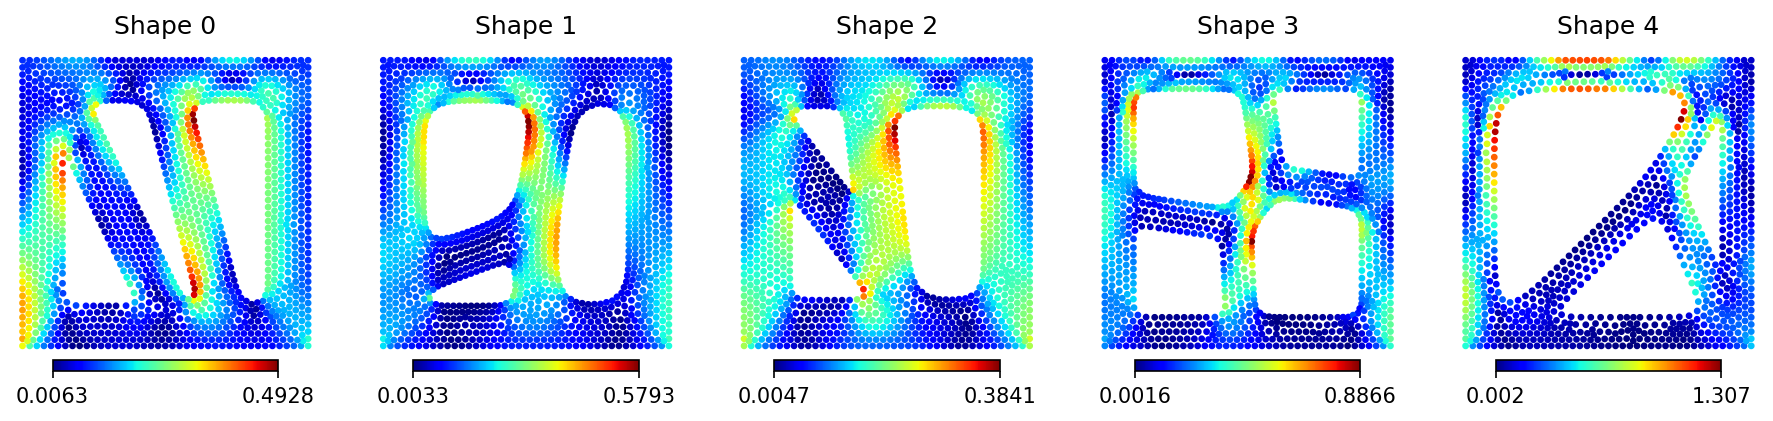

In [16]:
# YOUR CODE GOES HERE
# Define data_path
data_path = "data/stress_nodal_features.npy"

dataset_train, dataset_test, X_train, X_test, y_train, y_test = load_dataset(data_path)
N_train = len(dataset_train["stress"])
N_test = len(dataset_test["stress"])

plt.figure(figsize=[15,3.2], dpi=150)
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_shape(dataset_train,i)
    plt.title(f"Shape {i}")
plt.show()

## Fitting models with all features 
Create two models to fit the training data `X_train`, `y_train`:
1. A `LinearRegression()` model
2. A `DecisionTreeRegressor()` model with a `max_depth` of 20

Print the training and testing MSE for each.

In [42]:
# YOUR CODE GOES HERE
LR_ = LinearRegression()
DTR_ = DecisionTreeRegressor(max_depth = 20)

LR_.fit(X_train, y_train)
DTR_.fit(X_train, y_train)

mse_train_LR_ = mean_squared_error(y_train, LR_.predict(X_train))
mse_train_DTR_ = mean_squared_error(y_train, DTR_.predict(X_train))

mse_test_LR_ = mean_squared_error(y_test, LR_.predict(X_test))
mse_test_DTR_ = mean_squared_error(y_test, DTR_.predict(X_test))

print("Train MSE for Linear Regression Model: ", mse_train_LR_)
print("Test MSE for Linear Regression Model: ", mse_test_LR_)

print("\nTrain MSE for Decision Tree Regressor Model: ", mse_train_DTR_)
print("Test MSE for Decision Tree Regressor Model: ", mse_test_DTR_)


Train MSE for Linear Regression Model:  0.008110601
Test MSE for Linear Regression Model:  0.009779483

Train MSE for Decision Tree Regressor Model:  0.0004944875978805109
Test MSE for Decision Tree Regressor Model:  0.008307369037199367


## Visualization
Use the `plot_shape_comparison()` function to plot the index 8 shape results in `dataset_test` for each model.

Include titles to indicate which plot is which, using the `title` argument.

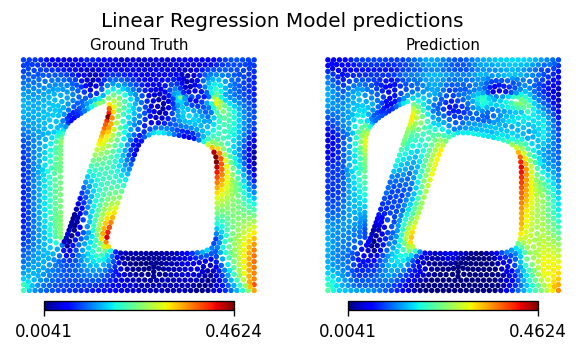

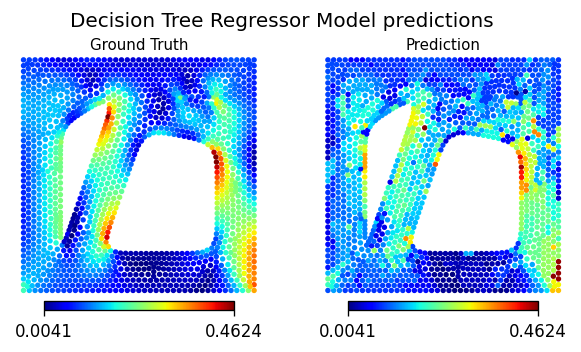

In [43]:
test_idx = 8

# YOUR CODE GOES HERE
plot_shape_comparison(dataset_test, test_idx, LR_, title = "Linear Regression Model predictions")
plot_shape_comparison(dataset_test, test_idx, DTR_, title = "Decision Tree Regressor Model predictions")


## Feature importance
For a tree methods, "feature importance" can be computed, which can be done for an sklearn model using `.feature_importances_`.  

Use the provided function `plot_importances()` to visualize which features are most important to the final decision tree prediction.  
Then create another plot using the same function to visualize the linear regression coefficients by setting the "coef" argument to `True`.

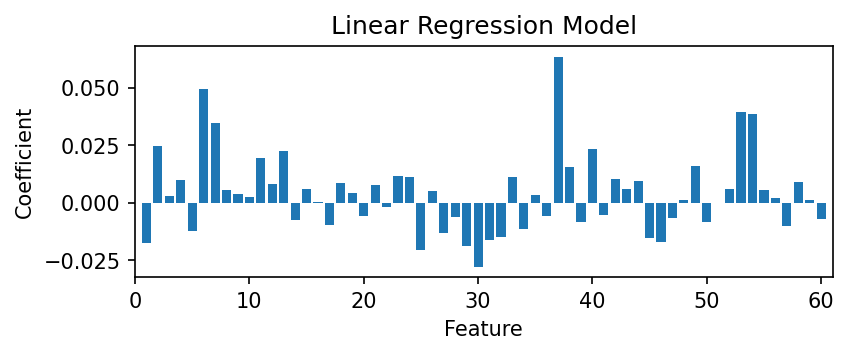

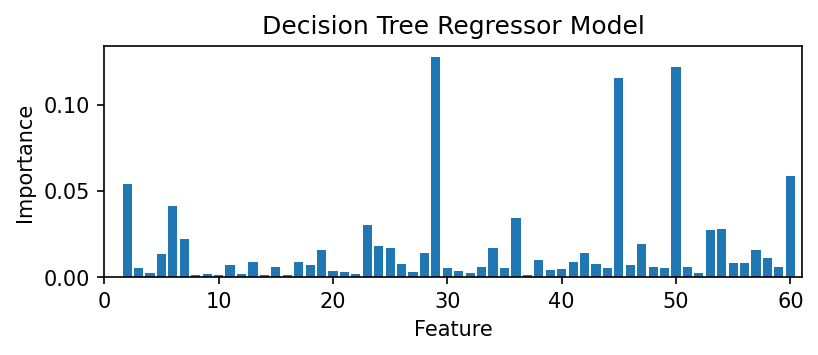

In [44]:
# YOUR CODE GOES HERE
plot_importances(LR_, coef = True, title = "Linear Regression Model")
plot_importances(DTR_, title = "Decision Tree Regressor Model")

## Feature Selection by Recursive Feature Elimination

Using `RFE()` in sklearn, you can iteratively select a subset of only the most important features.  

For both linear regression and decision tree (depth 20) models:
1. Create a new model.
2. Create an instance of `RFE()` with `n_features_to_select` set to 30.
3. Fit the RFE model as you would a normal sklearn model.
4. Report the train and test MSE.

Note that the decision tree RFE model may take a few minutes to train.  
Visit https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html for more information.


In [45]:
# YOUR CODE GOES HERE
RFE_LR_ = RFE(LR_, n_features_to_select = 30)
RFE_DTR_ = RFE(DTR_, n_features_to_select = 30)

RFE_LR_.fit(X_train, y_train)
RFE_DTR_.fit(X_train, y_train)

mse_train_rfe_lr = mean_squared_error(y_train, RFE_LR_.predict(X_train))
mse_train_rfe_dtr = mean_squared_error(y_train, RFE_DTR_.predict(X_train))

mse_test_rfe_lr = mean_squared_error(y_test, RFE_LR_.predict(X_test))
mse_test_rfe_dtr = mean_squared_error(y_test, RFE_DTR_.predict(X_test))

print("Train MSE after RFE on Linear Regression Model: ", mse_train_rfe_lr)
print("Test MSE after RFE on Linear Regression Model: ", mse_test_rfe_lr)

print("\nTrain MSE after RFE on Decision Tree Regressor Model: ", mse_train_rfe_dtr)
print("Test MSE after RFE on Decision Tree Regressor Model: ", mse_test_rfe_dtr)


Train MSE after RFE on Linear Regression Model:  0.008508719
Test MSE after RFE on Linear Regression Model:  0.010150376

Train MSE after RFE on Decision Tree Regressor Model:  0.0005512811770783042
Test MSE after RFE on Decision Tree Regressor Model:  0.009104145243788579


## Visualization 
Use the `plot_shape_comparison()` function to plot the index 16 shape results in `dataset_test` for each model.

As before, include titles to indicate which plot is which, using the `title` argument.

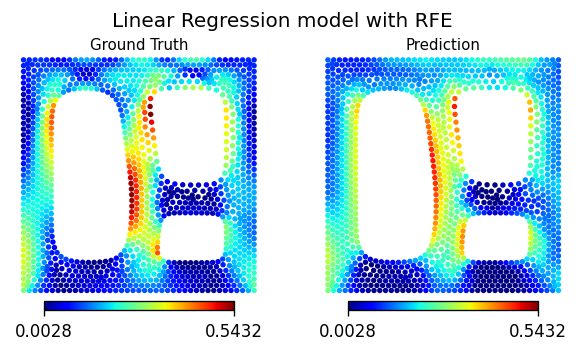

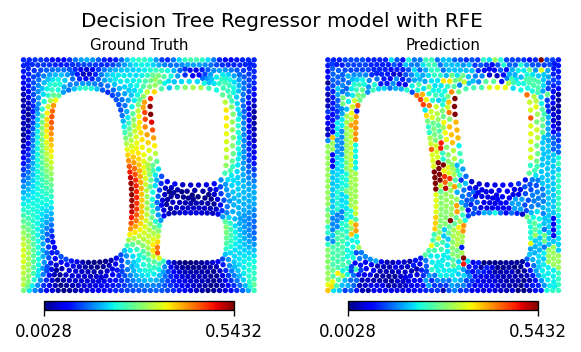

In [47]:
test_idx = 16

# YOUR CODE GOES HERE
plot_shape_comparison(dataset_test, test_idx, RFE_LR_, title = "Linear Regression model with RFE")
plot_shape_comparison(dataset_test, test_idx, RFE_DTR_, title = "Decision Tree Regressor model with RFE")

## Feature importance with RFE
Recreate the 2 feature importance/coefficent plots from earlier, but this time highlight which features were ultimately selected after performing RFE by coloring those features red. You can do this by setting the `selected` argument equal to an array of selected indices.  

For an RFE model `rfe`, the selected feature indices can be obtained via `rfe.get_support(indices=True)`.

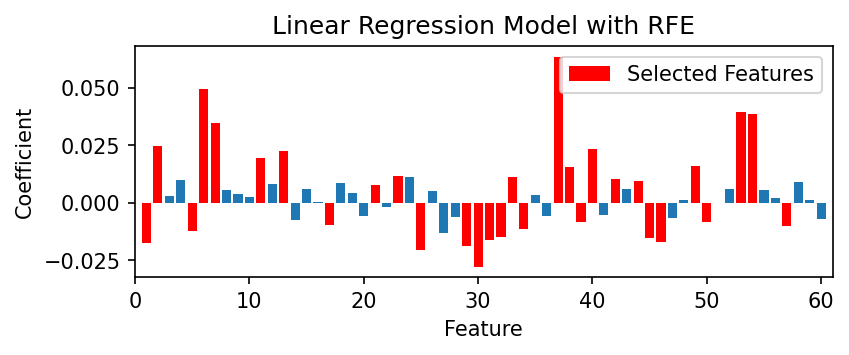

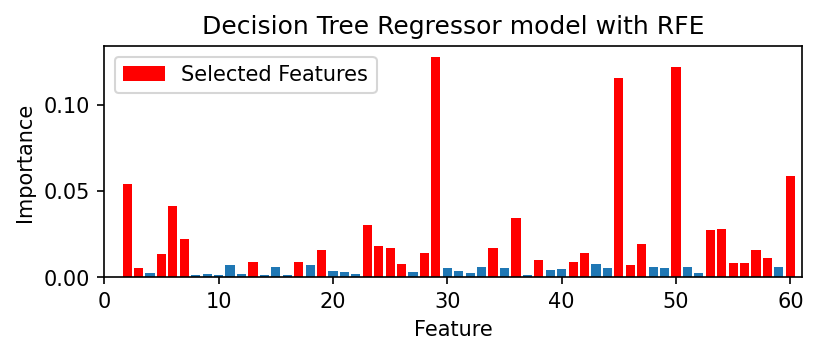

In [48]:
# YOUR CODE GOES HERE
plot_importances(model = LR_, selected = np.array(RFE_LR_.get_support(indices = True)), coef = True, title = "Linear Regression Model with RFE")
plot_importances(model = DTR_, selected = RFE_DTR_.get_support(indices = True), title = "Decision Tree Regressor model with RFE")

## Questions

1. Did the MSE increase or decrease on test data for the Linear Regression model after performing RFE?  


2. Did the MSE increase or decrease on test data for the Decision Tree model after performing RFE?  


3. Describe the qualitative differences between the Linear Regression and the Decision Tree predictions.  


4. Describe how the importance of features that were selected by RFE compare to that of features that were eliminated (for the decision tree).  


5. Describe how the coefficients that were selected by RFE compare to that of features that were eliminated (for linear regression).  



## Answers
1. For the Linear Regression model, the MSE on the test data increased after performing RFE
2. For the Decision Tree Regressor Model, the MSE on the test data increased after performing RFE
3. Linear Regression assumes a linear relationship between the features and output of the model, whereas decision tree are able to capture more complex information, and do not assume a specific form for the relationship between the features and the outputs
4. On plotting the feature importances, it is clear that RFE selected the 30 features with the higher importances magnitudes and neglected the others. Since all features have positive importance values, the ones with the lower magnitudes were neglected.
5. In this case, since there are both positive and negative values of feature importances, it seems like the features with the most importance in an absolute sense (magnitude) were selected by RFE.